In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from rim import RIM, Hourglass
import matplotlib.pyplo as plt
import numpy as np
import torch.distributions as tfd
from torch.func import vmap
from tqdm import tqdm

matmul = vmap(torch.matmul)

In [3]:
m = 16 # model space
n = 32 # observation space
modes = 10 # modes of the prior chosen at random in the prior space
mode_width = 0.5
coords = torch.randn([modes, m])

# Implementation of the zero temperature distributions
def make_prior():
    mean = coords
    scale = mode_width
    mixture = tfd.Categorical(torch.ones(modes), validate_args=False)
    component = tfd.Independent(tfd.Normal(mean, scale, validate_args=False), 1) # Uniform diagonal MVN
    return tfd.MixtureSameFamily(mixture, component, validate_args=False)

def make_likelihood(sigma_n):
    cov = torch.eye(n) * sigma_n**2
    return tfd.MultivariateNormal(torch.zeros(n), covariance_matrix=cov, validate_args=False)

def make_posterior(y, A, sigma_n):
    Sigma_x = torch.eye(m) * mode_width**2
    Sigma_y = torch.eye(n) * sigma_n**2
    Sigma_x_given_y = (Sigma_x.inverse() + A.T @ Sigma_y.inverse() @ A).inverse()
    mu_x_given_y = torch.stack([Sigma_x_given_y @ (coords[i] + A.T @ Sigma_y.inverse() @ y.view(-1)) for i in range(coords.shape[0])])
    mean = mu_x_given_y
    cov = Sigma_x_given_y
    mixture = tfd.Categorical(q, validate_args=False)
    component = tfd.MultivariateNormal(mean, covariance_matrix=cov, validate_args=False)
    return tfd.MixtureSameFamily(mixture, component, validate_args=False)

Epoch 50 | Cost: 1.7e+01 |: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:48<00:00,  2.17s/it]

Finished training after 0.030 hours.


Text(0.5, 0, 'Epoch')

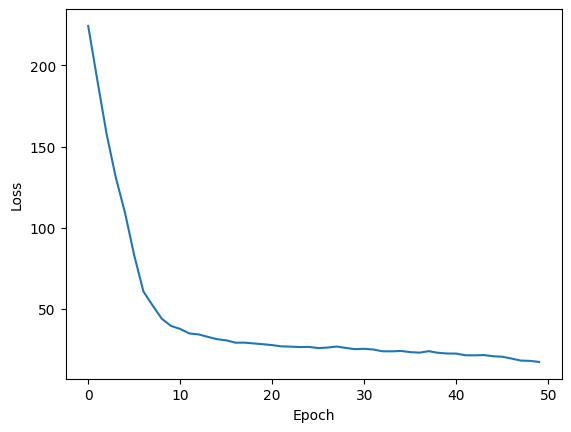

In [6]:
sigma_max = 1
sigma_min = 1e-2


@vmap
def score_fn(x, y, A, sigma_n): # make sure to respect this signature (x, y, *args)
    y_pred = A @ x.squeeze() # remove channel dimension of x.
    score = - (y - y_pred) @ (-A) / sigma_n**2
    return score.unsqueeze(0) # give score back its channel dimensions

prior = make_prior()

# Make a dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, size, ):
        self.size = size
    
    def __len__(self):
        return self.size
    
    def __getitem__(self, index):
        x = prior.sample([])
        A = torch.randn([n, m]) # forward model is random
        sigma_n = torch.rand([]) * (sigma_max - sigma_min) + sigma_min # the noise level is also random
        z = torch.randn([n]) * sigma_n # same shape as y
        y = A @ x + z
        w = torch.ones_like(x)
         # for dataset, it's the traditional ml signature (inputs, labels, *args)
        return y, x.view(1, -1), A, sigma_n # add channel dimension to x

dataset = Dataset(1000)
model = Hourglass(channels=1, nf=32, ch_mult=(2, 2))
rim = RIM([16], model, score_fn=score_fn)

losses = rim.fit(dataset, epochs=50, batch_size=100, learning_rate=1e-3)
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Epoch")

Text(0, 0.5, 'Value')

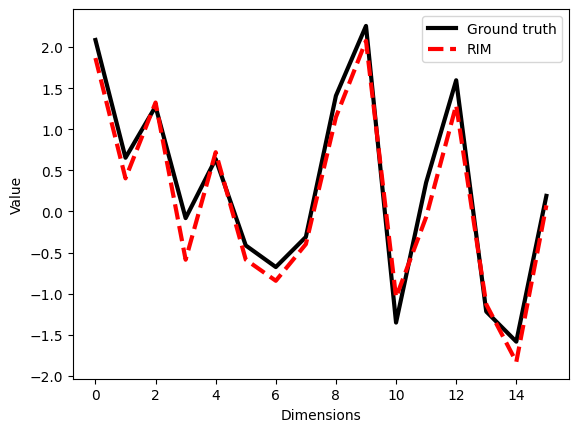

In [7]:
dataloader = torch.utils.data.DataLoader(dataset)
y, x_true, A, sigma_n = next(iter(dataloader))
with torch.no_grad():
    x_pred = rim.predict(y, A, sigma_n)
plt.plot(x_true.squeeze(), "-k", lw=3, label="Ground truth")
plt.plot(x_pred.squeeze(), "--r", lw=3, label="RIM")
plt.legend()
plt.xlabel("Dimensions")
plt.ylabel("Value")